In [1]:

from urllib.request import urlopen
from IPython.display import SVG
import matplotlib.pyplot as plt
from rdkit import Chem
import pickle
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import visualizer as visualizer
import utils as utils
import fragmentation_py as fragmentation_py
import library_downloader as library_downloader
import SiteLocator as modSite
import json

In [2]:
# library = "GNPS-LIBRARY"
library = "GNPS-MSMLS"
# library = "GNPS-NIH-NATURALPRODUCTSLIBRARY_ROUND2_POSITIVE"

# if directory does not exist, create it
if not os.path.exists( os.path.join("../data/libraries",library)):
    url = "https://gnps-external.ucsd.edu/gnpslibrary/" + library + ".json"
    location = "../data/libraries/" + library + "/"
    library_downloader.download(url, location, 0.5, 0.1)

# load data_dict_filtered
with open(os.path.join("../data/libraries",library,"data_dict_filtered.pkl"), "rb") as f:
    data_dict_filtered = pickle.load(f)

# load matches
with open(os.path.join("../data/libraries",library,"matches.pkl"), "rb") as f:
    matches = pickle.load(f)

# load cachedStructures_filtered
with open(os.path.join("../data/libraries",library,"cachedStructures.pkl"), "rb") as f:
    cachedStructures_filtered = pickle.load(f)

In [72]:
flag = False
founded = {"key":"", "peak":""}
for key in data_dict_filtered.keys():
    molMol = cachedStructures_filtered[key]
    fragments = fragmentation_py.FragmentEngine(Chem.MolToMolBlock(molMol), 4, 2, 1, 0, 0)
    numFrag = fragments.generate_fragments()
    peaks = json.loads(data_dict_filtered[key]["peaks_json"])
    MAX_intensity = max([peak[1] for peak in peaks])
    for peak in peaks:
        if peak[1] < 0.01 * MAX_intensity:
            continue
        if "+H" not in data_dict_filtered[key]["Adduct"]:
            continue
        finded_frags = fragments.find_fragments(peak[0], 0.1, 1.01, 0.05)
        if (len(finded_frags) == 0):
            print(key)
            founded["key"] = key
            founded["peak"] = peak
            flag = True
            break
    if flag:    
        break

CCMSLIB00005463556


In [54]:
founded = {}
# founded["key"] = "CCMSLIB00005463557"
# founded["key"] = "CCMSLIB00005463556"
# founded["key"] = "CCMSLIB00005464402"
founded["key"] = "CCMSLIB00005463542"

57 M+H 1
mzspec:GNPS:GNPS-MSMLS:accession:CCMSLIB00005463542


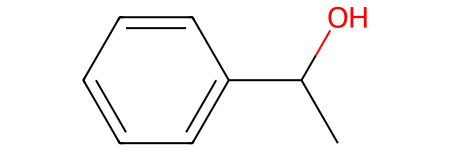

In [55]:
molData = data_dict_filtered[founded["key"]]
molMol = cachedStructures_filtered[founded["key"]]
fragments = fragmentation_py.FragmentEngine(Chem.MolToMolBlock(molMol), 2, 2, 1, 0, 0)
numFrag = fragments.generate_fragments()
peaks = json.loads(molData["peaks_json"])
print(numFrag, molData["Adduct"], molData["Charge"])
print("mzspec:GNPS:" + library + ":accession:" + founded["key"])
molMol

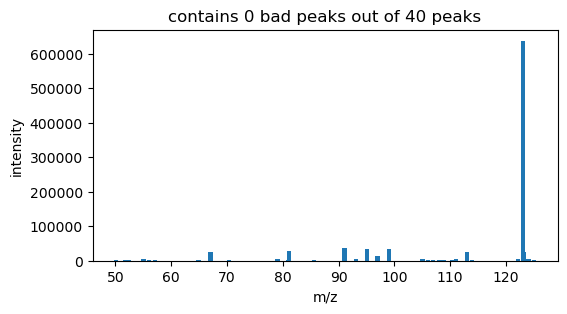

In [56]:
args = {"ppm": 1.01, "mz_tolerance": 0.1}
MAX_intensity = max([peak[1] for peak in peaks])
bad_peaks = []
for peak in peaks:
    if peak[1] < 0.01 * MAX_intensity:
        continue
    finded_frags = fragments.find_fragments(peak[0], 0.1, args["ppm"], args["mz_tolerance"])
    if (len(finded_frags) == 0):
        bad_peaks.append(peak[0])

# draw bar plot of peaks, highlight bad peaks
plt.figure(figsize=(6,3))
plt.bar([peak[0] for peak in peaks], [peak[1] for peak in peaks])
plt.bar(bad_peaks, [peak[1] for peak in peaks if peak[0] in bad_peaks], color="red")

#set titles
plt.title("contains " + str(len(bad_peaks)) + " bad peaks out of " + str(len(peaks)) + " peaks")
plt.xlabel("m/z")
plt.ylabel("intensity")

plt.show()

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import SVG
import ipywidgets as widgets
import math

def plot_peaks(peak):
    print("!", peak)
    if len(peak) == 0:
        return
    else:
        peak = peak[0]
    count = 0
    res = []
    print(peak)
    for frag in range(1 << molMol.GetNumAtoms()):
        (bondbreaks, score,) = fragments.score_fragment(frag)
        mass = fragments.calc_fragment_mass(frag) + 1.007276
        if (abs(mass - (peak)) < 1.5):
            print(frag, bondbreaks, score, mass)
            res.append(frag)
            count += 1

    print(count)
    x = math.floor(math.sqrt(count))
    print(x)
    y = math.ceil(count / x)
    fig, ax = plt.subplots(x, y, figsize=(10, 10))
    for i in range(x):
        for j in range(y):
            if (i * x + j < count):
                atoms_in = [_ for _ in range(1 << molMol.GetNumAtoms()) if (res[i * x + j] & (1 << _))]
                ax[i, j].imshow(Chem.Draw.MolToImage(molMol, size=(200, 200), highlightAtoms=atoms_in))
                weight = fragments.calc_fragment_mass(res[i * x + j])
                ax[i, j].set_title(str(res[i * x + j]) + " " + str(round(weight,4)))
    # remove space between subplots
    fig.subplots_adjust(wspace=0, hspace=0)

    fig.tight_layout()
    plt.show()
widgets.interact(plot_peaks, peak=widgets.SelectMultiple(options=bad_peaks))

interactive(children=(SelectMultiple(description='peak', options=(72.081116, 89.107384, 113.963776, 126.127708…

<function __main__.plot_peaks(peak)>

In [6]:
import math
count = 0
res = []
print(peak[0])
for frag in range(1 << molMol.GetNumAtoms()):
    (bondbreaks, score,) = fragments.score_fragment(frag)
    mass = fragments.calc_fragment_mass(frag) + 1.007276
    if (abs(mass - (peak[0])) < 1.5):
        print(frag, bondbreaks, score, mass)
        res.append(frag)
        count += 1

print(count)
x = math.floor(math.sqrt(count))
print(x)
y = math.ceil(count / x)
fig, ax = plt.subplots(x, y, figsize=(10, 10))
for i in range(x):
    for j in range(y):
        if (i * x + j < count):
            atoms_in = [_ for _ in range(1 << molMol.GetNumAtoms()) if (res[i * x + j] & (1 << _))]
            ax[i, j].imshow(Chem.Draw.MolToImage(molMol, size=(200, 200), highlightAtoms=atoms_in))
            weight = fragments.calc_fragment_mass(res[i * x + j])
            ax[i, j].set_title(str(res[i * x + j]) + " " + str(round(weight,4)))

[58.806496, 1592.249756]
score=0:  0 0


TypeError: unsupported operand type(s) for -: 'float' and 'list'

551 5 20.0 71.0371137878


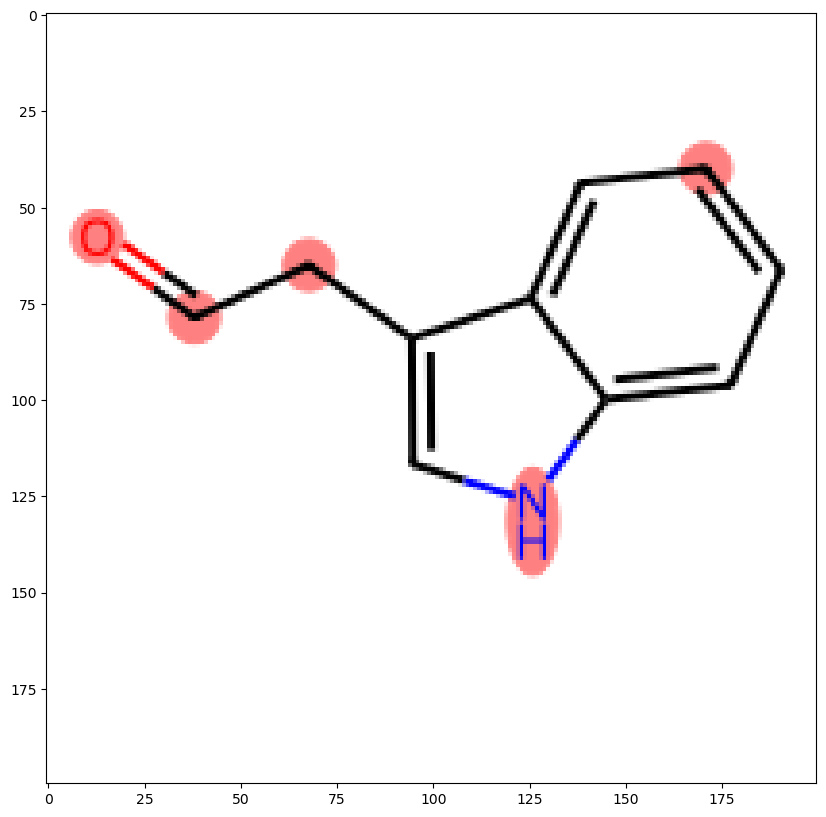

In [101]:
q = 295 ^ (1 << 8) ^ (1<<9)
(bondbreaks, score,) = fragments.score_fragment(q)
mass = fragments.calc_fragment_mass(q)
print(q, bondbreaks, score, mass)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
atoms_in = [_ for _ in range(1 << molMol.GetNumAtoms()) if (q & (1 << _))]
ax.imshow(Chem.Draw.MolToImage(molMol, size=(200, 200), highlightAtoms=atoms_in))

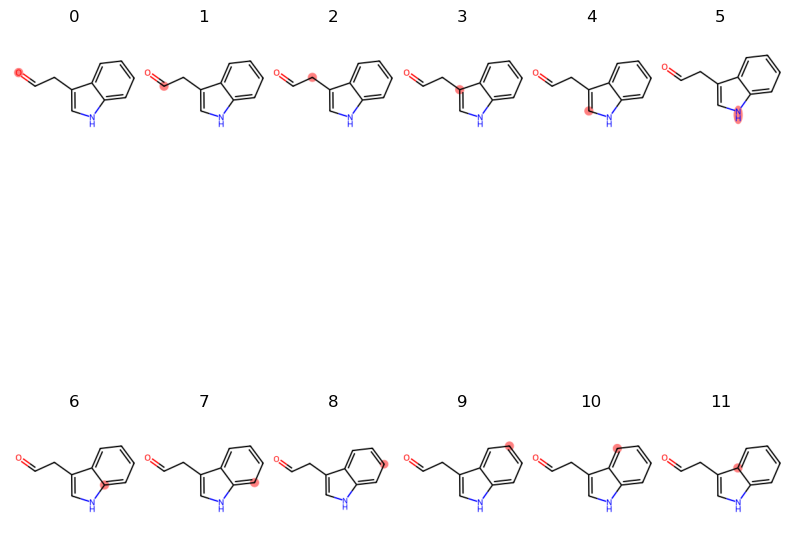

In [92]:
fig, ax = plt.subplots(2, math.ceil(molMol.GetNumAtoms()/2), figsize=(10, 10))
# remove space between subplots
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(molMol.GetNumAtoms()):
    row = i // math.ceil(molMol.GetNumAtoms()/2)
    col = i % math.ceil(molMol.GetNumAtoms()/2)
    ax[row, col].imshow(Chem.Draw.MolToImage(molMol, size=(200, 200), highlightAtoms=[i]))
    ax[row, col].set_title(i)
    ax[row, col].axis('off')


In [85]:
sorted_weights = sorted(fragments.fragment_masses)
range_weights = set()
for i in range(0, len(sorted_weights)):
    if sorted_weights[i] > peak[0] - 2 and sorted_weights[i] < peak[0] + 2:
        range_weights.add(sorted_weights[i])
print(range_weights)
print(fragments.find_fragments(peak[0], 0.1, 1.1, 0.1))

{71.0496898468}
[[4032, 9.0, 2, 76.0313001284, -1], [4032, 9.0, 2, 76.0313001284, 0], [4032, 9.0, 2, 76.0313001284, 1], [4032, 9.0, 2, 76.0313001284, 2], [4032, 9.0, 2, 76.0313001284, 3], [31, 9.0, 2, 68.0262147505, -1], [31, 9.0, 2, 68.0262147505, 0], [31, 9.0, 2, 68.0262147505, 1], [31, 9.0, 2, 68.0262147505, 2], [31, 9.0, 2, 68.0262147505, 3], [2168, 14.0, 3, 64.01872406940001, 2], [2168, 14.0, 3, 64.01872406940001, 3], [2168, 14.0, 3, 64.01872406940001, 4], [2296, 14.0, 3, 77.0265491015, -2], [2296, 14.0, 3, 77.0265491015, -1], [2296, 14.0, 3, 77.0265491015, 0], [2296, 14.0, 3, 77.0265491015, 1], [2296, 14.0, 3, 77.0265491015, 2], [2172, 14.0, 3, 78.0343741336, -2], [2172, 14.0, 3, 78.0343741336, -1], [2172, 14.0, 3, 78.0343741336, 0], [2172, 14.0, 3, 78.0343741336, 1], [3192, 14.0, 3, 77.0265491015, -2], [3192, 14.0, 3, 77.0265491015, -1], [3192, 14.0, 3, 77.0265491015, 0], [3192, 14.0, 3, 77.0265491015, 1], [3192, 14.0, 3, 77.0265491015, 2]]


In [27]:
print(len(fragments.fragment_info))

57


In [29]:
print(fragments.fragment_info)

[[0, 0, 0], [511, 0, 0], [510, 2.0, 1], [504, 2.0, 1], [1, 2.0, 1], [4, 1.0, 1], [507, 1.0, 1], [496, 12.0, 2], [7, 2.0, 1], [495, 12.0, 2], [479, 12.0, 2], [447, 12.0, 2], [383, 12.0, 2], [255, 12.0, 2], [240, 12.0, 2], [224, 12.0, 2], [15, 12.0, 2], [192, 12.0, 2], [31, 12.0, 2], [128, 12.0, 2], [63, 12.0, 2], [127, 12.0, 2], [6, 4.0, 2], [3, 3.0, 2], [256, 12.0, 2], [112, 12.0, 2], [96, 12.0, 2], [271, 12.0, 2], [64, 12.0, 2], [287, 12.0, 2], [319, 12.0, 2], [384, 12.0, 2], [48, 12.0, 2], [32, 12.0, 2], [399, 12.0, 2], [415, 12.0, 2], [448, 12.0, 2], [16, 12.0, 2], [463, 12.0, 2], [480, 12.0, 2], [506, 3.0, 2], [491, 13.0, 3], [475, 13.0, 3], [443, 13.0, 3], [379, 13.0, 3], [251, 13.0, 3], [11, 13.0, 3], [27, 13.0, 3], [59, 13.0, 3], [123, 13.0, 3], [2, 5.0, 3], [267, 13.0, 3], [283, 13.0, 3], [315, 13.0, 3], [395, 13.0, 3], [411, 13.0, 3], [459, 13.0, 3]]
